***
    
Demo EvoJAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Korteweg–De Vries equation 
    
    2. Optimize PINN using xNES + NAG solver in the JAX framework
<!--        -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022). -->

# Demo

In [1]:
# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# import library
import numpy as np
import time

# import problem
from kdv import get_fitness, policy # Number of parameters: 240

xNES +NAG Solver

In [2]:
from jax import random, numpy as jnp
from jax.scipy.linalg import expm
from jax import jit, vmap
seed = 1
def xNES_NAG(f, x0, bs=20, lr=1e-3, sigma=1, maxtime=60, momentum_coeff=0.9, verbose=False):
    
    """ [xNES_NAG]
    Implemented baseline algo.: Exponential NES (xNES) as described in Glasmachers, Schaul, Sun, Wierstra and Schmidhuber (GECCO'10).
    Maximizes a function f. Returns (best solution found, corresponding fitness, etc.).
    
    Added Nesterov Accelerated Gradient (NAG) 
    """
    # Initialize random generator (+ seed)
    
    key, rng = random.split(random.PRNGKey(seed))
    
    # target search
    center = x0.copy()
    dim = len(x0)
    I = jnp.eye(dim)
    A = I * sigma
    momentum = jnp.zeros(dim)
    bestFitness = -jnp.inf    
    learningRate = lr     # a same learning rate apply to all updates (including mixture model coef.)
    batchSize = bs    
    bestFound = None
    bestFitness = -jnp.inf
    
    loss_ls = []
    t_training_ls = []
    
    @jit
    def project_sample(center, A, momentum, rng):
        center_proj = center + momentum_coeff * momentum
        # produce and evaluate samples
        key, rng = random.split(rng) # update random generator
        samples = random.normal(key, [batchSize, dim])
        samples_o = jnp.dot(samples, A) + center_proj
        return (samples, samples_o, rng)

    @jit
    def computeUtilities(fitnesses):
        l = jnp.argsort(fitnesses)
        ranks = jnp.argsort(l)
        L = fitnesses.size
        # smooth reshaping
        utilities = jnp.array([jnp.maximum(0., x) for x in jnp.log(L / 2. + 1.0) - jnp.log(L - jnp.array(ranks))])
        utilities /= sum(utilities)       # make the utilities sum to 1
        utilities -= 1. / L  # baseline
        return utilities

    @jit
    def update_parameters(center, A, momentum, utilities, samples):    
        # NAG parameter updates
        update_center = jnp.dot(A, jnp.dot(utilities, samples)) + momentum_coeff * momentum
        momentum = update_center
        # update center and variances
        center += update_center   
        covGradient = sum([u * (jnp.outer(s, s) - I) for (s, u) in zip(samples, utilities)])
        A = jnp.dot(A, expm(0.5 * learningRate * covGradient))
        return (center, A, momentum)
  
    
    # loop
    numEvals = 0
    t_training = 0
    while t_training <= maxtime:
        start = time.time()
        # do partial update (project into new center) & produce samples
        samples, samples_o, rng = project_sample(center, A, momentum, rng)        
        # evaluate sample fitness
        fitnesses = f(samples_o)
        # return best fitness and solution
        if max(fitnesses) > bestFitness:
            _bestFitness = jnp.argmax(fitnesses)
            bestFitness, bestFound = fitnesses[_bestFitness], samples_o[_bestFitness]
        # update no. evaluations 
        numEvals += batchSize
        # print progress
        if verbose:
            print ("Step %5d | lr %.1e | numEvals %7d  : %.3e   [Best: %.5e]" %(numEvals/batchSize, lr, numEvals,
                                                                                max(fitnesses), bestFitness))        
        
        # fitness shaping
        utilities = computeUtilities(fitnesses)
        # parameter updates
        center, A, momentum = update_parameters(center, A, momentum, utilities, samples)
        end = time.time()
        t_training += (end-start)
        
        t_training_ls.append(t_training)
        loss_ls.append(bestFitness)
        
    print("...\nRunning time: %d secs!" %(t_training))
    print("\nNo of iterations: %d iterations!" %(numEvals/batchSize))
    return bestFound, bestFitness, numEvals, t_training_ls, loss_ls


Training

In [3]:
# optimize PINN (no source -> xNES)
w0 = jnp.zeros(policy.num_params)
op_weight, op_fitness, evals, t_training_ls, loss_ls = xNES_NAG(get_fitness, w0, bs=100, lr=0.01, sigma=0.001, momentum_coeff=0.9, verbose=True)

Step     1 | lr 1.0e-02 | numEvals     100  : -1.078e-01   [Best: -1.07818e-01]
Step     2 | lr 1.0e-02 | numEvals     200  : -1.078e-01   [Best: -1.07818e-01]
Step     3 | lr 1.0e-02 | numEvals     300  : -1.078e-01   [Best: -1.07811e-01]
Step     4 | lr 1.0e-02 | numEvals     400  : -1.078e-01   [Best: -1.07799e-01]
Step     5 | lr 1.0e-02 | numEvals     500  : -1.078e-01   [Best: -1.07769e-01]
Step     6 | lr 1.0e-02 | numEvals     600  : -1.077e-01   [Best: -1.07727e-01]
Step     7 | lr 1.0e-02 | numEvals     700  : -1.077e-01   [Best: -1.07655e-01]
Step     8 | lr 1.0e-02 | numEvals     800  : -1.076e-01   [Best: -1.07551e-01]
Step     9 | lr 1.0e-02 | numEvals     900  : -1.074e-01   [Best: -1.07416e-01]
Step    10 | lr 1.0e-02 | numEvals    1000  : -1.073e-01   [Best: -1.07257e-01]
Step    11 | lr 1.0e-02 | numEvals    1100  : -1.070e-01   [Best: -1.07031e-01]
Step    12 | lr 1.0e-02 | numEvals    1200  : -1.068e-01   [Best: -1.06761e-01]
Step    13 | lr 1.0e-02 | numEvals    13

Step   111 | lr 1.0e-02 | numEvals   11100  : -6.039e-02   [Best: -6.03911e-02]
Step   112 | lr 1.0e-02 | numEvals   11200  : -6.039e-02   [Best: -6.03910e-02]
Step   113 | lr 1.0e-02 | numEvals   11300  : -6.039e-02   [Best: -6.03908e-02]
Step   114 | lr 1.0e-02 | numEvals   11400  : -6.039e-02   [Best: -6.03907e-02]
Step   115 | lr 1.0e-02 | numEvals   11500  : -6.039e-02   [Best: -6.03905e-02]
Step   116 | lr 1.0e-02 | numEvals   11600  : -6.039e-02   [Best: -6.03904e-02]
Step   117 | lr 1.0e-02 | numEvals   11700  : -6.039e-02   [Best: -6.03902e-02]
Step   118 | lr 1.0e-02 | numEvals   11800  : -6.039e-02   [Best: -6.03899e-02]
Step   119 | lr 1.0e-02 | numEvals   11900  : -6.039e-02   [Best: -6.03896e-02]
Step   120 | lr 1.0e-02 | numEvals   12000  : -6.039e-02   [Best: -6.03893e-02]
Step   121 | lr 1.0e-02 | numEvals   12100  : -6.039e-02   [Best: -6.03890e-02]
Step   122 | lr 1.0e-02 | numEvals   12200  : -6.039e-02   [Best: -6.03886e-02]
Step   123 | lr 1.0e-02 | numEvals   123

Step   217 | lr 1.0e-02 | numEvals   21700  : -5.325e-02   [Best: -5.32545e-02]
Step   218 | lr 1.0e-02 | numEvals   21800  : -5.317e-02   [Best: -5.31696e-02]
Step   219 | lr 1.0e-02 | numEvals   21900  : -5.309e-02   [Best: -5.30944e-02]
Step   220 | lr 1.0e-02 | numEvals   22000  : -5.299e-02   [Best: -5.29867e-02]
Step   221 | lr 1.0e-02 | numEvals   22100  : -5.290e-02   [Best: -5.28975e-02]
Step   222 | lr 1.0e-02 | numEvals   22200  : -5.280e-02   [Best: -5.27964e-02]
Step   223 | lr 1.0e-02 | numEvals   22300  : -5.268e-02   [Best: -5.26819e-02]
Step   224 | lr 1.0e-02 | numEvals   22400  : -5.258e-02   [Best: -5.25847e-02]
Step   225 | lr 1.0e-02 | numEvals   22500  : -5.249e-02   [Best: -5.24947e-02]
Step   226 | lr 1.0e-02 | numEvals   22600  : -5.240e-02   [Best: -5.24014e-02]
Step   227 | lr 1.0e-02 | numEvals   22700  : -5.232e-02   [Best: -5.23241e-02]
Step   228 | lr 1.0e-02 | numEvals   22800  : -5.226e-02   [Best: -5.22576e-02]
Step   229 | lr 1.0e-02 | numEvals   229

Step   321 | lr 1.0e-02 | numEvals   32100  : -4.941e-02   [Best: -4.94110e-02]
Step   322 | lr 1.0e-02 | numEvals   32200  : -4.936e-02   [Best: -4.93593e-02]
Step   323 | lr 1.0e-02 | numEvals   32300  : -4.929e-02   [Best: -4.92941e-02]
Step   324 | lr 1.0e-02 | numEvals   32400  : -4.924e-02   [Best: -4.92402e-02]
Step   325 | lr 1.0e-02 | numEvals   32500  : -4.918e-02   [Best: -4.91767e-02]
Step   326 | lr 1.0e-02 | numEvals   32600  : -4.912e-02   [Best: -4.91153e-02]
Step   327 | lr 1.0e-02 | numEvals   32700  : -4.905e-02   [Best: -4.90530e-02]
Step   328 | lr 1.0e-02 | numEvals   32800  : -4.898e-02   [Best: -4.89838e-02]
Step   329 | lr 1.0e-02 | numEvals   32900  : -4.892e-02   [Best: -4.89155e-02]
Step   330 | lr 1.0e-02 | numEvals   33000  : -4.884e-02   [Best: -4.88417e-02]
Step   331 | lr 1.0e-02 | numEvals   33100  : -4.877e-02   [Best: -4.87692e-02]
Step   332 | lr 1.0e-02 | numEvals   33200  : -4.869e-02   [Best: -4.86947e-02]
Step   333 | lr 1.0e-02 | numEvals   333

Step   428 | lr 1.0e-02 | numEvals   42800  : -3.980e-02   [Best: -3.98046e-02]
Step   429 | lr 1.0e-02 | numEvals   42900  : -3.951e-02   [Best: -3.95098e-02]
Step   430 | lr 1.0e-02 | numEvals   43000  : -3.926e-02   [Best: -3.92600e-02]
Step   431 | lr 1.0e-02 | numEvals   43100  : -3.895e-02   [Best: -3.89536e-02]
Step   432 | lr 1.0e-02 | numEvals   43200  : -3.866e-02   [Best: -3.86571e-02]
Step   433 | lr 1.0e-02 | numEvals   43300  : -3.832e-02   [Best: -3.83189e-02]
Step   434 | lr 1.0e-02 | numEvals   43400  : -3.799e-02   [Best: -3.79851e-02]
Step   435 | lr 1.0e-02 | numEvals   43500  : -3.765e-02   [Best: -3.76546e-02]
Step   436 | lr 1.0e-02 | numEvals   43600  : -3.727e-02   [Best: -3.72749e-02]
Step   437 | lr 1.0e-02 | numEvals   43700  : -3.695e-02   [Best: -3.69458e-02]
Step   438 | lr 1.0e-02 | numEvals   43800  : -3.659e-02   [Best: -3.65859e-02]
Step   439 | lr 1.0e-02 | numEvals   43900  : -3.618e-02   [Best: -3.61819e-02]
Step   440 | lr 1.0e-02 | numEvals   440

Step   536 | lr 1.0e-02 | numEvals   53600  : -1.102e-02   [Best: -1.10216e-02]
Step   537 | lr 1.0e-02 | numEvals   53700  : -1.096e-02   [Best: -1.09592e-02]
Step   538 | lr 1.0e-02 | numEvals   53800  : -1.089e-02   [Best: -1.08907e-02]
Step   539 | lr 1.0e-02 | numEvals   53900  : -1.080e-02   [Best: -1.08039e-02]
Step   540 | lr 1.0e-02 | numEvals   54000  : -1.073e-02   [Best: -1.07322e-02]
Step   541 | lr 1.0e-02 | numEvals   54100  : -1.065e-02   [Best: -1.06482e-02]
Step   542 | lr 1.0e-02 | numEvals   54200  : -1.056e-02   [Best: -1.05559e-02]
Step   543 | lr 1.0e-02 | numEvals   54300  : -1.048e-02   [Best: -1.04781e-02]
Step   544 | lr 1.0e-02 | numEvals   54400  : -1.039e-02   [Best: -1.03948e-02]
Step   545 | lr 1.0e-02 | numEvals   54500  : -1.032e-02   [Best: -1.03170e-02]
Step   546 | lr 1.0e-02 | numEvals   54600  : -1.023e-02   [Best: -1.02327e-02]
Step   547 | lr 1.0e-02 | numEvals   54700  : -1.015e-02   [Best: -1.01546e-02]
Step   548 | lr 1.0e-02 | numEvals   548

Step   643 | lr 1.0e-02 | numEvals   64300  : -7.906e-03   [Best: -7.90640e-03]
Step   644 | lr 1.0e-02 | numEvals   64400  : -7.890e-03   [Best: -7.88993e-03]
Step   645 | lr 1.0e-02 | numEvals   64500  : -7.870e-03   [Best: -7.87039e-03]
Step   646 | lr 1.0e-02 | numEvals   64600  : -7.852e-03   [Best: -7.85188e-03]
Step   647 | lr 1.0e-02 | numEvals   64700  : -7.831e-03   [Best: -7.83059e-03]
Step   648 | lr 1.0e-02 | numEvals   64800  : -7.811e-03   [Best: -7.81080e-03]
Step   649 | lr 1.0e-02 | numEvals   64900  : -7.794e-03   [Best: -7.79382e-03]
Step   650 | lr 1.0e-02 | numEvals   65000  : -7.773e-03   [Best: -7.77323e-03]
Step   651 | lr 1.0e-02 | numEvals   65100  : -7.755e-03   [Best: -7.75519e-03]
Step   652 | lr 1.0e-02 | numEvals   65200  : -7.737e-03   [Best: -7.73702e-03]
Step   653 | lr 1.0e-02 | numEvals   65300  : -7.717e-03   [Best: -7.71669e-03]
Step   654 | lr 1.0e-02 | numEvals   65400  : -7.699e-03   [Best: -7.69852e-03]
Step   655 | lr 1.0e-02 | numEvals   655

Step   747 | lr 1.0e-02 | numEvals   74700  : -6.135e-03   [Best: -6.13456e-03]
Step   748 | lr 1.0e-02 | numEvals   74800  : -6.111e-03   [Best: -6.11105e-03]
Step   749 | lr 1.0e-02 | numEvals   74900  : -6.088e-03   [Best: -6.08840e-03]
Step   750 | lr 1.0e-02 | numEvals   75000  : -6.067e-03   [Best: -6.06683e-03]
Step   751 | lr 1.0e-02 | numEvals   75100  : -6.046e-03   [Best: -6.04585e-03]
Step   752 | lr 1.0e-02 | numEvals   75200  : -6.023e-03   [Best: -6.02272e-03]
Step   753 | lr 1.0e-02 | numEvals   75300  : -6.001e-03   [Best: -6.00100e-03]
Step   754 | lr 1.0e-02 | numEvals   75400  : -5.979e-03   [Best: -5.97875e-03]
Step   755 | lr 1.0e-02 | numEvals   75500  : -5.956e-03   [Best: -5.95560e-03]
Step   756 | lr 1.0e-02 | numEvals   75600  : -5.933e-03   [Best: -5.93317e-03]
Step   757 | lr 1.0e-02 | numEvals   75700  : -5.909e-03   [Best: -5.90919e-03]
Step   758 | lr 1.0e-02 | numEvals   75800  : -5.886e-03   [Best: -5.88599e-03]
Step   759 | lr 1.0e-02 | numEvals   759

Step   854 | lr 1.0e-02 | numEvals   85400  : -3.939e-03   [Best: -3.93923e-03]
Step   855 | lr 1.0e-02 | numEvals   85500  : -3.921e-03   [Best: -3.92121e-03]
Step   856 | lr 1.0e-02 | numEvals   85600  : -3.893e-03   [Best: -3.89339e-03]
Step   857 | lr 1.0e-02 | numEvals   85700  : -3.876e-03   [Best: -3.87650e-03]
Step   858 | lr 1.0e-02 | numEvals   85800  : -3.853e-03   [Best: -3.85297e-03]
Step   859 | lr 1.0e-02 | numEvals   85900  : -3.835e-03   [Best: -3.83470e-03]
Step   860 | lr 1.0e-02 | numEvals   86000  : -3.810e-03   [Best: -3.80998e-03]
Step   861 | lr 1.0e-02 | numEvals   86100  : -3.786e-03   [Best: -3.78590e-03]
Step   862 | lr 1.0e-02 | numEvals   86200  : -3.768e-03   [Best: -3.76795e-03]
Step   863 | lr 1.0e-02 | numEvals   86300  : -3.751e-03   [Best: -3.75093e-03]
Step   864 | lr 1.0e-02 | numEvals   86400  : -3.722e-03   [Best: -3.72213e-03]
Step   865 | lr 1.0e-02 | numEvals   86500  : -3.706e-03   [Best: -3.70581e-03]
Step   866 | lr 1.0e-02 | numEvals   866

Step   959 | lr 1.0e-02 | numEvals   95900  : -2.831e-03   [Best: -2.83115e-03]
Step   960 | lr 1.0e-02 | numEvals   96000  : -2.827e-03   [Best: -2.82712e-03]
Step   961 | lr 1.0e-02 | numEvals   96100  : -2.824e-03   [Best: -2.82407e-03]
Step   962 | lr 1.0e-02 | numEvals   96200  : -2.819e-03   [Best: -2.81875e-03]
Step   963 | lr 1.0e-02 | numEvals   96300  : -2.816e-03   [Best: -2.81619e-03]
Step   964 | lr 1.0e-02 | numEvals   96400  : -2.811e-03   [Best: -2.81126e-03]
Step   965 | lr 1.0e-02 | numEvals   96500  : -2.808e-03   [Best: -2.80842e-03]
Step   966 | lr 1.0e-02 | numEvals   96600  : -2.799e-03   [Best: -2.79937e-03]
Step   967 | lr 1.0e-02 | numEvals   96700  : -2.799e-03   [Best: -2.79878e-03]
Step   968 | lr 1.0e-02 | numEvals   96800  : -2.794e-03   [Best: -2.79445e-03]
Step   969 | lr 1.0e-02 | numEvals   96900  : -2.791e-03   [Best: -2.79138e-03]
Step   970 | lr 1.0e-02 | numEvals   97000  : -2.787e-03   [Best: -2.78686e-03]
Step   971 | lr 1.0e-02 | numEvals   971

Step  1067 | lr 1.0e-02 | numEvals  106700  : -2.482e-03   [Best: -2.48186e-03]
Step  1068 | lr 1.0e-02 | numEvals  106800  : -2.480e-03   [Best: -2.47988e-03]
Step  1069 | lr 1.0e-02 | numEvals  106900  : -2.475e-03   [Best: -2.47502e-03]
Step  1070 | lr 1.0e-02 | numEvals  107000  : -2.468e-03   [Best: -2.46849e-03]
Step  1071 | lr 1.0e-02 | numEvals  107100  : -2.468e-03   [Best: -2.46807e-03]
Step  1072 | lr 1.0e-02 | numEvals  107200  : -2.464e-03   [Best: -2.46414e-03]
Step  1073 | lr 1.0e-02 | numEvals  107300  : -2.462e-03   [Best: -2.46166e-03]
Step  1074 | lr 1.0e-02 | numEvals  107400  : -2.459e-03   [Best: -2.45890e-03]
Step  1075 | lr 1.0e-02 | numEvals  107500  : -2.456e-03   [Best: -2.45609e-03]
Step  1076 | lr 1.0e-02 | numEvals  107600  : -2.449e-03   [Best: -2.44945e-03]
Step  1077 | lr 1.0e-02 | numEvals  107700  : -2.449e-03   [Best: -2.44937e-03]
Step  1078 | lr 1.0e-02 | numEvals  107800  : -2.444e-03   [Best: -2.44412e-03]
Step  1079 | lr 1.0e-02 | numEvals  1079

Step  1173 | lr 1.0e-02 | numEvals  117300  : -2.137e-03   [Best: -2.13744e-03]
Step  1174 | lr 1.0e-02 | numEvals  117400  : -2.134e-03   [Best: -2.13431e-03]
Step  1175 | lr 1.0e-02 | numEvals  117500  : -2.130e-03   [Best: -2.13028e-03]
Step  1176 | lr 1.0e-02 | numEvals  117600  : -2.127e-03   [Best: -2.12745e-03]
Step  1177 | lr 1.0e-02 | numEvals  117700  : -2.125e-03   [Best: -2.12500e-03]
Step  1178 | lr 1.0e-02 | numEvals  117800  : -2.120e-03   [Best: -2.11975e-03]
Step  1179 | lr 1.0e-02 | numEvals  117900  : -2.118e-03   [Best: -2.11757e-03]
Step  1180 | lr 1.0e-02 | numEvals  118000  : -2.113e-03   [Best: -2.11314e-03]
Step  1181 | lr 1.0e-02 | numEvals  118100  : -2.109e-03   [Best: -2.10947e-03]
Step  1182 | lr 1.0e-02 | numEvals  118200  : -2.107e-03   [Best: -2.10747e-03]
Step  1183 | lr 1.0e-02 | numEvals  118300  : -2.101e-03   [Best: -2.10133e-03]
Step  1184 | lr 1.0e-02 | numEvals  118400  : -2.097e-03   [Best: -2.09668e-03]
Step  1185 | lr 1.0e-02 | numEvals  1185

Step  1278 | lr 1.0e-02 | numEvals  127800  : -1.744e-03   [Best: -1.74384e-03]
Step  1279 | lr 1.0e-02 | numEvals  127900  : -1.742e-03   [Best: -1.74229e-03]
Step  1280 | lr 1.0e-02 | numEvals  128000  : -1.738e-03   [Best: -1.73769e-03]
Step  1281 | lr 1.0e-02 | numEvals  128100  : -1.735e-03   [Best: -1.73498e-03]
Step  1282 | lr 1.0e-02 | numEvals  128200  : -1.732e-03   [Best: -1.73239e-03]
Step  1283 | lr 1.0e-02 | numEvals  128300  : -1.726e-03   [Best: -1.72646e-03]
Step  1284 | lr 1.0e-02 | numEvals  128400  : -1.724e-03   [Best: -1.72387e-03]
Step  1285 | lr 1.0e-02 | numEvals  128500  : -1.722e-03   [Best: -1.72207e-03]
Step  1286 | lr 1.0e-02 | numEvals  128600  : -1.717e-03   [Best: -1.71687e-03]
Step  1287 | lr 1.0e-02 | numEvals  128700  : -1.715e-03   [Best: -1.71498e-03]
Step  1288 | lr 1.0e-02 | numEvals  128800  : -1.712e-03   [Best: -1.71193e-03]
Step  1289 | lr 1.0e-02 | numEvals  128900  : -1.708e-03   [Best: -1.70798e-03]
Step  1290 | lr 1.0e-02 | numEvals  1290

Step  1387 | lr 1.0e-02 | numEvals  138700  : -1.459e-03   [Best: -1.45918e-03]
Step  1388 | lr 1.0e-02 | numEvals  138800  : -1.455e-03   [Best: -1.45537e-03]
Step  1389 | lr 1.0e-02 | numEvals  138900  : -1.456e-03   [Best: -1.45537e-03]
Step  1390 | lr 1.0e-02 | numEvals  139000  : -1.452e-03   [Best: -1.45234e-03]
Step  1391 | lr 1.0e-02 | numEvals  139100  : -1.449e-03   [Best: -1.44874e-03]
Step  1392 | lr 1.0e-02 | numEvals  139200  : -1.449e-03   [Best: -1.44874e-03]
Step  1393 | lr 1.0e-02 | numEvals  139300  : -1.447e-03   [Best: -1.44659e-03]
Step  1394 | lr 1.0e-02 | numEvals  139400  : -1.446e-03   [Best: -1.44566e-03]
Step  1395 | lr 1.0e-02 | numEvals  139500  : -1.443e-03   [Best: -1.44284e-03]
Step  1396 | lr 1.0e-02 | numEvals  139600  : -1.440e-03   [Best: -1.44009e-03]
Step  1397 | lr 1.0e-02 | numEvals  139700  : -1.440e-03   [Best: -1.44009e-03]
Step  1398 | lr 1.0e-02 | numEvals  139800  : -1.437e-03   [Best: -1.43697e-03]
Step  1399 | lr 1.0e-02 | numEvals  1399

Step  1495 | lr 1.0e-02 | numEvals  149500  : -1.244e-03   [Best: -1.24357e-03]
Step  1496 | lr 1.0e-02 | numEvals  149600  : -1.242e-03   [Best: -1.24216e-03]
Step  1497 | lr 1.0e-02 | numEvals  149700  : -1.240e-03   [Best: -1.23991e-03]
Step  1498 | lr 1.0e-02 | numEvals  149800  : -1.238e-03   [Best: -1.23796e-03]
Step  1499 | lr 1.0e-02 | numEvals  149900  : -1.236e-03   [Best: -1.23609e-03]
Step  1500 | lr 1.0e-02 | numEvals  150000  : -1.235e-03   [Best: -1.23543e-03]
Step  1501 | lr 1.0e-02 | numEvals  150100  : -1.230e-03   [Best: -1.23018e-03]
Step  1502 | lr 1.0e-02 | numEvals  150200  : -1.229e-03   [Best: -1.22911e-03]
Step  1503 | lr 1.0e-02 | numEvals  150300  : -1.228e-03   [Best: -1.22799e-03]
Step  1504 | lr 1.0e-02 | numEvals  150400  : -1.226e-03   [Best: -1.22596e-03]
Step  1505 | lr 1.0e-02 | numEvals  150500  : -1.223e-03   [Best: -1.22313e-03]
Step  1506 | lr 1.0e-02 | numEvals  150600  : -1.221e-03   [Best: -1.22108e-03]
Step  1507 | lr 1.0e-02 | numEvals  1507

Step  1604 | lr 1.0e-02 | numEvals  160400  : -1.045e-03   [Best: -1.04456e-03]
Step  1605 | lr 1.0e-02 | numEvals  160500  : -1.043e-03   [Best: -1.04332e-03]
Step  1606 | lr 1.0e-02 | numEvals  160600  : -1.042e-03   [Best: -1.04200e-03]
Step  1607 | lr 1.0e-02 | numEvals  160700  : -1.041e-03   [Best: -1.04073e-03]
Step  1608 | lr 1.0e-02 | numEvals  160800  : -1.039e-03   [Best: -1.03925e-03]
Step  1609 | lr 1.0e-02 | numEvals  160900  : -1.036e-03   [Best: -1.03568e-03]
Step  1610 | lr 1.0e-02 | numEvals  161000  : -1.034e-03   [Best: -1.03433e-03]
Step  1611 | lr 1.0e-02 | numEvals  161100  : -1.034e-03   [Best: -1.03354e-03]
Step  1612 | lr 1.0e-02 | numEvals  161200  : -1.033e-03   [Best: -1.03347e-03]
Step  1613 | lr 1.0e-02 | numEvals  161300  : -1.032e-03   [Best: -1.03167e-03]
Step  1614 | lr 1.0e-02 | numEvals  161400  : -1.031e-03   [Best: -1.03135e-03]
Step  1615 | lr 1.0e-02 | numEvals  161500  : -1.030e-03   [Best: -1.03023e-03]
Step  1616 | lr 1.0e-02 | numEvals  1616

Step  1712 | lr 1.0e-02 | numEvals  171200  : -8.725e-04   [Best: -8.72473e-04]
Step  1713 | lr 1.0e-02 | numEvals  171300  : -8.709e-04   [Best: -8.70889e-04]
Step  1714 | lr 1.0e-02 | numEvals  171400  : -8.694e-04   [Best: -8.69431e-04]
Step  1715 | lr 1.0e-02 | numEvals  171500  : -8.689e-04   [Best: -8.68929e-04]
Step  1716 | lr 1.0e-02 | numEvals  171600  : -8.665e-04   [Best: -8.66515e-04]
Step  1717 | lr 1.0e-02 | numEvals  171700  : -8.655e-04   [Best: -8.65491e-04]
Step  1718 | lr 1.0e-02 | numEvals  171800  : -8.637e-04   [Best: -8.63739e-04]
Step  1719 | lr 1.0e-02 | numEvals  171900  : -8.622e-04   [Best: -8.62155e-04]
Step  1720 | lr 1.0e-02 | numEvals  172000  : -8.647e-04   [Best: -8.62155e-04]
Step  1721 | lr 1.0e-02 | numEvals  172100  : -8.638e-04   [Best: -8.62155e-04]
Step  1722 | lr 1.0e-02 | numEvals  172200  : -8.625e-04   [Best: -8.62155e-04]
Step  1723 | lr 1.0e-02 | numEvals  172300  : -8.574e-04   [Best: -8.57376e-04]
Step  1724 | lr 1.0e-02 | numEvals  1724

Step  1815 | lr 1.0e-02 | numEvals  181500  : -7.533e-04   [Best: -7.53284e-04]
Step  1816 | lr 1.0e-02 | numEvals  181600  : -7.622e-04   [Best: -7.53284e-04]
Step  1817 | lr 1.0e-02 | numEvals  181700  : -7.561e-04   [Best: -7.53284e-04]
Step  1818 | lr 1.0e-02 | numEvals  181800  : -7.548e-04   [Best: -7.53284e-04]
Step  1819 | lr 1.0e-02 | numEvals  181900  : -7.519e-04   [Best: -7.51869e-04]
Step  1820 | lr 1.0e-02 | numEvals  182000  : -7.591e-04   [Best: -7.51869e-04]
Step  1821 | lr 1.0e-02 | numEvals  182100  : -7.532e-04   [Best: -7.51869e-04]
Step  1822 | lr 1.0e-02 | numEvals  182200  : -7.478e-04   [Best: -7.47804e-04]
Step  1823 | lr 1.0e-02 | numEvals  182300  : -7.472e-04   [Best: -7.47201e-04]
Step  1824 | lr 1.0e-02 | numEvals  182400  : -7.461e-04   [Best: -7.46120e-04]
Step  1825 | lr 1.0e-02 | numEvals  182500  : -7.433e-04   [Best: -7.43313e-04]
Step  1826 | lr 1.0e-02 | numEvals  182600  : -7.434e-04   [Best: -7.43313e-04]
Step  1827 | lr 1.0e-02 | numEvals  1827

Step  1925 | lr 1.0e-02 | numEvals  192500  : -6.796e-04   [Best: -6.73771e-04]
Step  1926 | lr 1.0e-02 | numEvals  192600  : -6.754e-04   [Best: -6.73771e-04]
Step  1927 | lr 1.0e-02 | numEvals  192700  : -6.756e-04   [Best: -6.73771e-04]
Step  1928 | lr 1.0e-02 | numEvals  192800  : -6.749e-04   [Best: -6.73771e-04]
Step  1929 | lr 1.0e-02 | numEvals  192900  : -6.735e-04   [Best: -6.73470e-04]
Step  1930 | lr 1.0e-02 | numEvals  193000  : -6.741e-04   [Best: -6.73470e-04]
Step  1931 | lr 1.0e-02 | numEvals  193100  : -6.740e-04   [Best: -6.73470e-04]
Step  1932 | lr 1.0e-02 | numEvals  193200  : -6.722e-04   [Best: -6.72245e-04]
Step  1933 | lr 1.0e-02 | numEvals  193300  : -6.702e-04   [Best: -6.70244e-04]
Step  1934 | lr 1.0e-02 | numEvals  193400  : -6.719e-04   [Best: -6.70244e-04]
Step  1935 | lr 1.0e-02 | numEvals  193500  : -6.695e-04   [Best: -6.69517e-04]
Step  1936 | lr 1.0e-02 | numEvals  193600  : -6.693e-04   [Best: -6.69256e-04]
Step  1937 | lr 1.0e-02 | numEvals  1937

Step  2032 | lr 1.0e-02 | numEvals  203200  : -5.897e-04   [Best: -5.88272e-04]
Step  2033 | lr 1.0e-02 | numEvals  203300  : -5.887e-04   [Best: -5.88272e-04]
Step  2034 | lr 1.0e-02 | numEvals  203400  : -5.854e-04   [Best: -5.85432e-04]
Step  2035 | lr 1.0e-02 | numEvals  203500  : -5.852e-04   [Best: -5.85163e-04]
Step  2036 | lr 1.0e-02 | numEvals  203600  : -5.870e-04   [Best: -5.85163e-04]
Step  2037 | lr 1.0e-02 | numEvals  203700  : -5.852e-04   [Best: -5.85163e-04]
Step  2038 | lr 1.0e-02 | numEvals  203800  : -5.850e-04   [Best: -5.85046e-04]
Step  2039 | lr 1.0e-02 | numEvals  203900  : -5.854e-04   [Best: -5.85046e-04]
Step  2040 | lr 1.0e-02 | numEvals  204000  : -5.825e-04   [Best: -5.82515e-04]
Step  2041 | lr 1.0e-02 | numEvals  204100  : -5.810e-04   [Best: -5.80977e-04]
Step  2042 | lr 1.0e-02 | numEvals  204200  : -5.827e-04   [Best: -5.80977e-04]
Step  2043 | lr 1.0e-02 | numEvals  204300  : -5.836e-04   [Best: -5.80977e-04]
Step  2044 | lr 1.0e-02 | numEvals  2044

Step  2140 | lr 1.0e-02 | numEvals  214000  : -5.152e-04   [Best: -5.15188e-04]
Step  2141 | lr 1.0e-02 | numEvals  214100  : -5.220e-04   [Best: -5.15188e-04]
Step  2142 | lr 1.0e-02 | numEvals  214200  : -5.218e-04   [Best: -5.15188e-04]
Step  2143 | lr 1.0e-02 | numEvals  214300  : -5.155e-04   [Best: -5.15188e-04]
Step  2144 | lr 1.0e-02 | numEvals  214400  : -5.191e-04   [Best: -5.15188e-04]
Step  2145 | lr 1.0e-02 | numEvals  214500  : -5.161e-04   [Best: -5.15188e-04]
Step  2146 | lr 1.0e-02 | numEvals  214600  : -5.167e-04   [Best: -5.15188e-04]
Step  2147 | lr 1.0e-02 | numEvals  214700  : -5.137e-04   [Best: -5.13749e-04]
Step  2148 | lr 1.0e-02 | numEvals  214800  : -5.126e-04   [Best: -5.12567e-04]
Step  2149 | lr 1.0e-02 | numEvals  214900  : -5.091e-04   [Best: -5.09076e-04]
Step  2150 | lr 1.0e-02 | numEvals  215000  : -5.094e-04   [Best: -5.09076e-04]
Step  2151 | lr 1.0e-02 | numEvals  215100  : -5.105e-04   [Best: -5.09076e-04]
Step  2152 | lr 1.0e-02 | numEvals  2152

Step  2247 | lr 1.0e-02 | numEvals  224700  : -4.555e-04   [Best: -4.50323e-04]
Step  2248 | lr 1.0e-02 | numEvals  224800  : -4.527e-04   [Best: -4.50323e-04]
Step  2249 | lr 1.0e-02 | numEvals  224900  : -4.527e-04   [Best: -4.50323e-04]
Step  2250 | lr 1.0e-02 | numEvals  225000  : -4.495e-04   [Best: -4.49548e-04]
Step  2251 | lr 1.0e-02 | numEvals  225100  : -4.523e-04   [Best: -4.49548e-04]
Step  2252 | lr 1.0e-02 | numEvals  225200  : -4.549e-04   [Best: -4.49548e-04]
Step  2253 | lr 1.0e-02 | numEvals  225300  : -4.545e-04   [Best: -4.49548e-04]
Step  2254 | lr 1.0e-02 | numEvals  225400  : -4.551e-04   [Best: -4.49548e-04]
Step  2255 | lr 1.0e-02 | numEvals  225500  : -4.490e-04   [Best: -4.48999e-04]
Step  2256 | lr 1.0e-02 | numEvals  225600  : -4.509e-04   [Best: -4.48999e-04]
Step  2257 | lr 1.0e-02 | numEvals  225700  : -4.538e-04   [Best: -4.48999e-04]
Step  2258 | lr 1.0e-02 | numEvals  225800  : -4.469e-04   [Best: -4.46897e-04]
Step  2259 | lr 1.0e-02 | numEvals  2259

Step  2351 | lr 1.0e-02 | numEvals  235100  : -3.978e-04   [Best: -3.94852e-04]
Step  2352 | lr 1.0e-02 | numEvals  235200  : -4.004e-04   [Best: -3.94852e-04]
Step  2353 | lr 1.0e-02 | numEvals  235300  : -3.972e-04   [Best: -3.94852e-04]
Step  2354 | lr 1.0e-02 | numEvals  235400  : -3.942e-04   [Best: -3.94238e-04]
Step  2355 | lr 1.0e-02 | numEvals  235500  : -3.896e-04   [Best: -3.89589e-04]
Step  2356 | lr 1.0e-02 | numEvals  235600  : -3.942e-04   [Best: -3.89589e-04]
Step  2357 | lr 1.0e-02 | numEvals  235700  : -3.989e-04   [Best: -3.89589e-04]
Step  2358 | lr 1.0e-02 | numEvals  235800  : -4.014e-04   [Best: -3.89589e-04]
Step  2359 | lr 1.0e-02 | numEvals  235900  : -3.996e-04   [Best: -3.89589e-04]
Step  2360 | lr 1.0e-02 | numEvals  236000  : -3.940e-04   [Best: -3.89589e-04]
Step  2361 | lr 1.0e-02 | numEvals  236100  : -3.913e-04   [Best: -3.89589e-04]
Step  2362 | lr 1.0e-02 | numEvals  236200  : -3.943e-04   [Best: -3.89589e-04]
Step  2363 | lr 1.0e-02 | numEvals  2363

Visualize optimzied PINN

In [4]:
from kdv import PINNs
from flax.core.frozen_dict import unfreeze, freeze
from jax import random, numpy as jnp
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
this_dict = policy._format_params_fn(jnp.array([op_weight]))
new_dict = unfreeze(this_dict)
for key1, value1 in new_dict.items():
    for key2, value2 in value1.items():
        for key3, value3 in value2.items():
            new_dict[key1][key2][key3] = value3[0]
new_dict = freeze(new_dict)

In [6]:
# Read data
sim = pd.read_csv('kdv.csv')
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
domain = (x_train[:,0] >= 0.0) & (x_train[:,0] <= 1.5)
batch_X, batch_y = x_train[domain], y_train[domain]
# PINN prediction
hello = PINNs()
prediction = hello.apply(new_dict, batch_X)
u = prediction[:,0:1]

DeviceArray(0.00075786, dtype=float32)

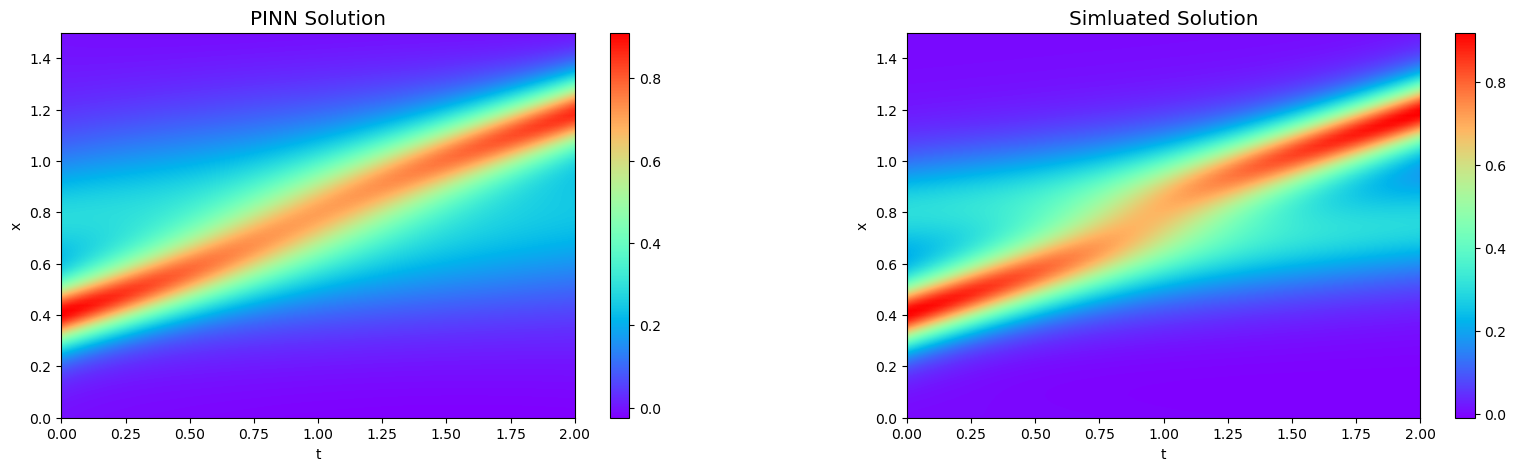

In [7]:
# plot & mse
fig = plt.figure(figsize=(20, 5))
u_viz = (u.reshape(201, 77)).T 
ext = [0 ,2, 0., 1.5]     # plot boundary  
ax1 = fig.add_subplot(1,2,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1); 
plt.colorbar(mesh) 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN Solution', fontsize='x-large'); 

u_true = (batch_y.reshape(201, 77)).T 
ext = [0 ,2, 0., 1.5]     # plot boundary    
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=1); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated Solution', fontsize='x-large'); 

jnp.mean((u_viz - u_true)**2)

Write PINN prediction & ground truth to file

In [8]:
#np.save('kdv_cma_60s', (u_viz, u_true))